In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [3]:
!unzip -qo ~/stanford-dogs-dataset.zip -d ./data/stanford-dogs


In [4]:
print(os.listdir('./data/stanford-dogs'))


['images', 'annotations']


In [42]:
path = "./data/stanford-dogs/images/Images"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # instead of rescale=1/255
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=1337
)

valid_generator = valid_datagen.flow_from_directory(
    path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=1337
)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [40]:
def generator_to_numpy(generator):
    x, y = [], []
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        x.append(batch_x)
        y.append(batch_y)
    return np.concatenate(x, axis=0), np.concatenate(y, axis=0)

x_test, y_test = generator_to_numpy(valid_generator)

In [41]:
y_test.shape

(4072, 120)

In [6]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
callbacks = [
    ModelCheckpoint(
        'mobilenetv2_best.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=3,
        verbose=1,
        restore_best_weights=True
    ),
]

In [23]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.0513 - loss: 4.6666
Epoch 1: val_loss improved from inf to 3.09036, saving model to mobilenetv2_best.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 106s 408ms/step - accuracy: 0.0516 - loss: 4.6647 - val_accuracy: 0.3944 - val_loss: 3.0904
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3644 - loss: 2.9312
Epoch 2: val_loss improved from 3.09036 to 2.03754, saving model to mobilenetv2_best.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 116s 450ms/step - accuracy: 0.3646 - loss: 2.9302 - val_accuracy: 0.6282 - val_loss: 2.0375
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.5571 - loss: 2.0447
Epoch 3: val_loss improved from 2.03754 to 1.50522, saving model to mobilenetv2_best.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 126s 489ms/step - accuracy: 0.5572 - loss: 2.0443 - val_accuracy: 0.7009 - val_loss: 1.5052
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6320 - loss: 1.6047
Epoch 4: val_los

In [24]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= 64, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.7816 - loss: 0.7735
Validation Loss:  0.7447984218597412
Validation Accuracy:  0.7919940948486328


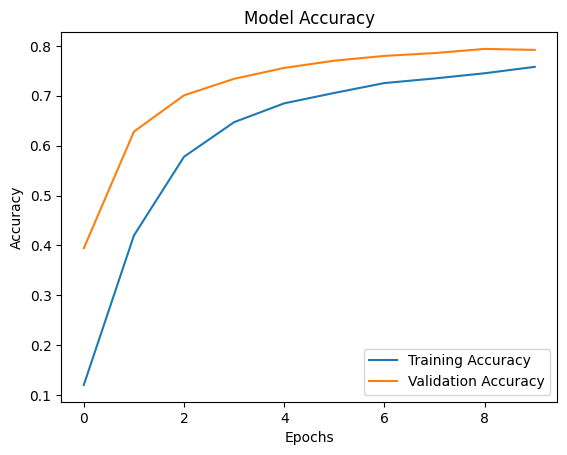

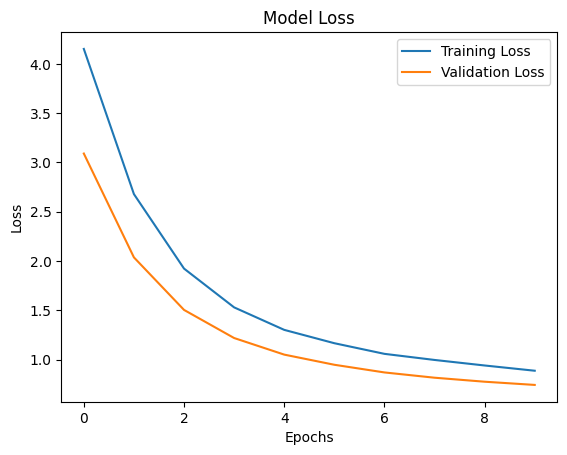

In [25]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [26]:
inputs = Input(shape=(224, 224, 3))

base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(120, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()


/var/folders/q2/v14my5x946b7x25sxwf5z0nh0000gn/T/ipykernel_8583/1566847846.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
feature_extractor = Model(inputs=model.input, outputs=x)

In [31]:
inputs = Input(shape=(224, 224, 3))
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(120, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


/var/folders/q2/v14my5x946b7x25sxwf5z0nh0000gn/T/ipykernel_8583/2972047260.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


In [32]:
features = []
labels = []

for i in range(len(valid_generator)):
    x_batch, y_batch = valid_generator[i]
    f_batch = feature_extractor.predict(x_batch)
    features.append(f_batch)
    labels.append(y_batch)

    if (i + 1) * valid_generator.batch_size >= valid_generator.samples:
        break

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

from sklearn.manifold import TSNE

reducer = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = reducer.fit_transform(features)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value enc

In [33]:
N = 2000 
features_subset = features[:N]
labels_subset = labels[:N]

In [34]:
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = reducer.fit_transform(features_subset)


/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value enc

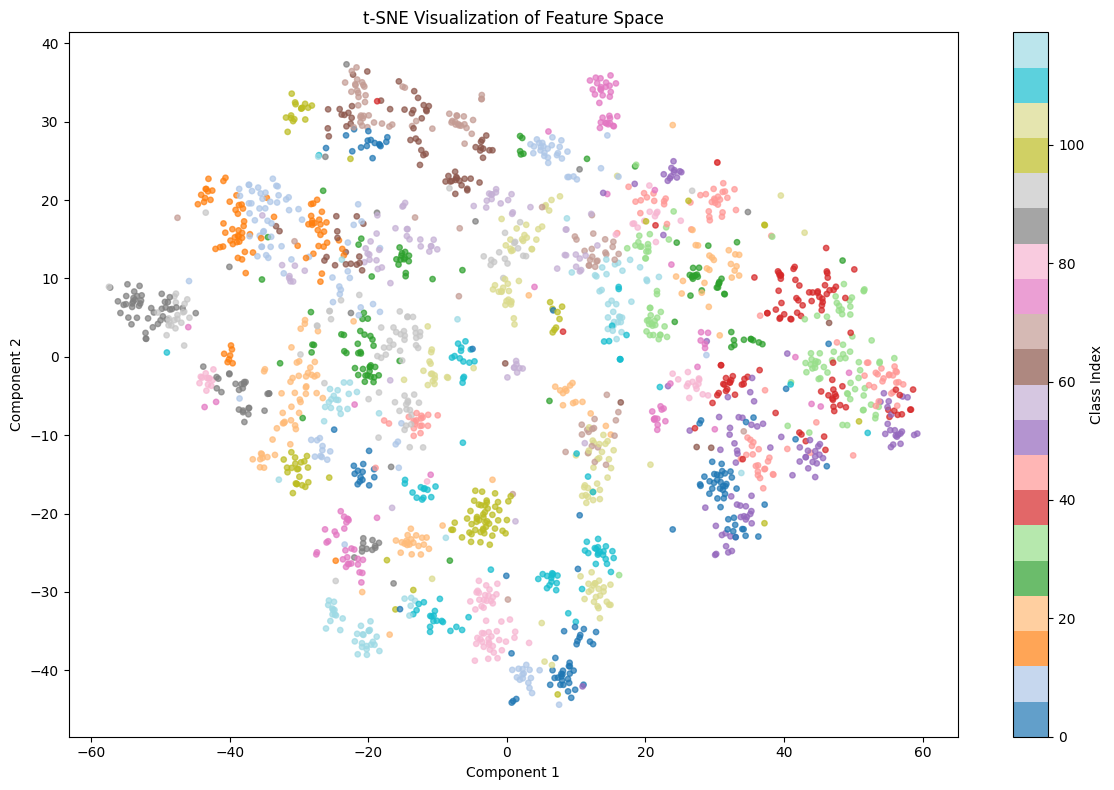

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=np.argmax(labels_subset, axis=1),  
    cmap='tab20',
    s=15,
    alpha=0.7
)
plt.colorbar(scatter, label='Class Index')
plt.title("t-SNE Visualization of Feature Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ashwin/.pyenv/versions/tf-env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value enc

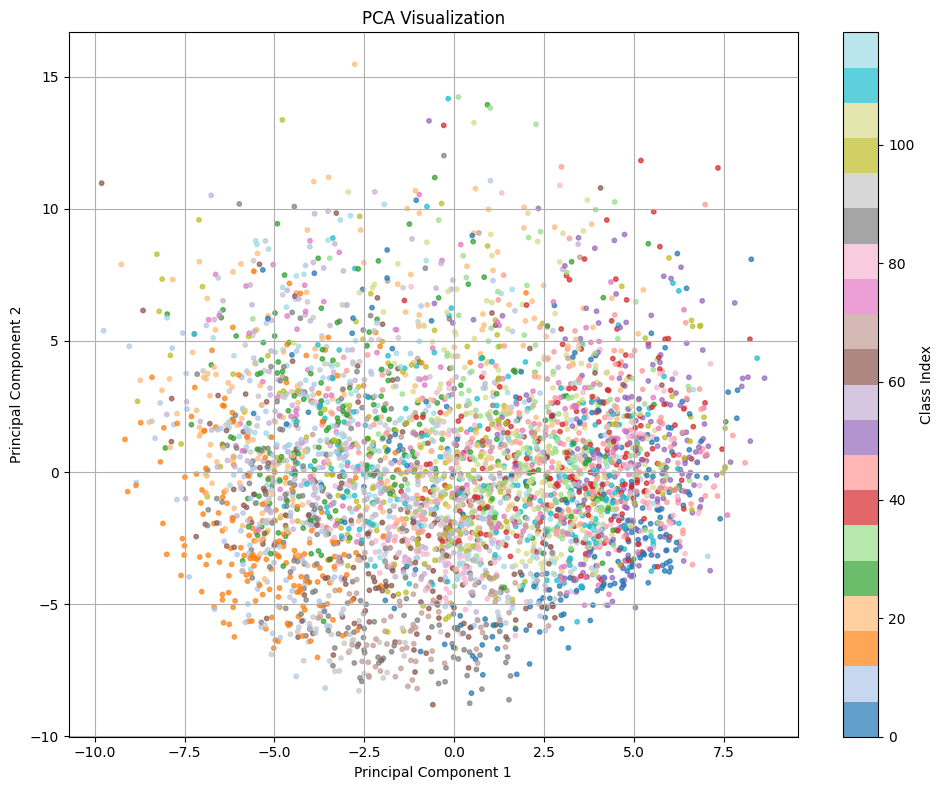

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

label_indices = np.argmax(y_test, axis=1)

pca = PCA(n_components=2)
features_2d_pca = pca.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    features_2d_pca[:, 0], features_2d_pca[:, 1],
    c=label_indices, cmap='tab20', s=10, alpha=0.7
)
plt.colorbar(scatter, label='Class Index')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()
